# Classification Stimulation-Imagination

## Apprentissage sur Foot; Test sur Hand

Region motrice seulement - Parcellation BASC 

22s - SVM Linéaire


In [15]:
import numpy as np

from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score

%matplotlib inline
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPPlot import plot_selectedregions

In [16]:
# Import data
names='ap','as','boh','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
smt='ss'
fold_g = 'F:/IRM_Marche/'
label_i=np.loadtxt(fold_g+'label_main.txt','S12')
blocks_i=np.loadtxt(fold_g+'block_main.txt','int')

roi=np.zeros([0,444])
rest=np.zeros([0,444])
label=np.zeros([0,3])
blocks=np.array([])
for n in names:
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    #rest_filename=  fold_g+'mni4060/asymroirest_'+smt+'_'+n+'.npz'  
    tmproi=np.load(sim_filename)['roi']
    #tmprest=np.load(rest_filename)['roi']
    roi=np.concatenate((roi,tmproi))
    #rest=np.concatenate((rest,tmprest))
    label=np.append(label,label_i,axis=0)
    blocks=np.append(blocks,blocks_i) 
    
# Remove first volumes per block    
index=[]
for x in range(label.shape[0]):
    if label[x,0]!=label[x-1,0]:
        index.append(x)
    elif label[x,0]!=label[x-2,0]:
        index.append(x)
        
label=np.delete(label,index,0)
blocks=np.delete(blocks,index,0)
roi=np.delete(roi,index,0)

condition_cat = np.logical_or(label[:,1] == b'foot', label[:,1] == b'hand')
condition_out=np.logical_not(label[:,2]== b'des')
condition_mask= condition_cat==condition_out
block=blocks[condition_mask]
y=label[condition_mask]
cond=roi[condition_mask]
   
train_mask= y[:,1]==b'foot'
test_mask= y[:,1]==b'hand'
y_train=y[train_mask,0]
y_test=y[test_mask,0]
roi_train=cond[train_mask]#   
roi_test=cond[test_mask]
block=block[train_mask]

## Data indiv

index_i=[]
nb_s=len(names)
for x in range(label_i.shape[0]):
    if label_i[x,0]!=label_i[x-1,0]:
        index_i.append(x)
    elif label_i[x,0]!=label_i[x-2,0]:
        index_i.append(x)
        
label_i=np.delete(label_i,index_i,0)
blocks_i=np.delete(blocks_i,index_i,0)

condition_cat_i = np.logical_or(label_i[:,1] == b'foot', label_i[:,1] == b'hand')
condition_out_i=np.logical_not(label_i[:,2]== b'des')
condition_mask_i= condition_cat_i==condition_out_i
block_i=blocks_i[condition_mask_i]
y_i=label_i[condition_mask_i]

   
train_mask_i= y_i[:,1]==b'foot'
test_mask_i= y_i[:,1]==b'hand'
y_train_i=y_i[train_mask_i,0]
y_test_i=y_i[test_mask_i,0]
  
block_i=block_i[test_mask_i]

In [17]:
# Classification
scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)
    
from sklearn.ensemble import ExtraTreesClassifier
#svm = ExtraTreesClassifier(n_estimators=1000,
#                              max_features=5,
#                              random_state=0,
#                           class_weight ='balanced')
from sklearn.linear_model import LogisticRegression
#svm=LogisticRegression(penalty='l1')
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])

In [18]:
# Prepare ploting
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']
brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory_level=1, verbose=0,
                           detrend=True, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels'
                           )
masker.fit()

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


NiftiLabelsMasker(background_label=0, detrend=True, high_pass=0.01,
         labels_img='C:\\Users\\mmenoret/nilearn_data\\basc_multiscale_2015\\template_cambridge_basc_multiscale_nii_asym\\template_cambridge_basc_multiscale_asym_scale444.nii.gz',
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x00000000147CBC50>,
         memory=Memory(cachedir=None), memory_level=1,
         resampling_target='labels', sessions=None, smoothing_fwhm=None,
         standardize=False, t_r=2.28, verbose=0)

### Classification seulement sur regions BASC motrices

In [19]:
motor_region_index=np.fromfile('F:/IRM_Marche/masquesROI/reg_sma_basc444asym.np','int')
#motor_region_index=np.fromfile('F:/IRM_Marche/harv_motorlarge_basc444asym.np',dtype=int)
#motor_region_index=np.fromfile('F:/IRM_Marche/masquesROI/reg_all_nooccipital_basc444asym.np','int')
print(motor_region_index)

[ 67  89 147 230 392 397 421 424 428]


In [20]:
result_i=np.zeros(nb_s)
pipeline = Pipeline([('scale', scaler),('classif_name', svm)])
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    roi_m=roi_i[:,motor_region_index-1]
    cond_i=roi_m[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    roi_train_i=cond_i[train_mask_i]# 
    pipeline.fit(roi_train_i, y_train_i)
    prediction = pipeline.predict(roi_test_i) 
    result_i[ni]=accuracy_score(prediction,y_test_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
print(result_i.mean())

ap Accuracy: 52.6315789474 %
as Accuracy: 41.2280701754 %
boh Accuracy: 44.7368421053 %
bh Accuracy: 54.3859649123 %
bi Accuracy: 53.5087719298 %
cmp Accuracy: 55.2631578947 %
cas Accuracy: 60.5263157895 %
cs Accuracy: 57.0175438596 %
cb Accuracy: 72.8070175439 %
gm Accuracy: 52.6315789474 %
gn Accuracy: 57.0175438596 %
gbn Accuracy: 45.6140350877 %
mv Accuracy: 52.6315789474 %
ms Accuracy: 48.2456140351 %
pm Accuracy: 42.1052631579 %
pc Accuracy: 58.7719298246 %
ph Accuracy: 49.1228070175 %
pa Accuracy: 73.6842105263 %
pv Accuracy: 41.2280701754 %
pom Accuracy: 70.1754385965 %
rdc Accuracy: 47.3684210526 %
ti Accuracy: 65.7894736842 %
vs Accuracy: 39.4736842105 %
0.537376048818


In [21]:
for ni,n in enumerate(names):
    sim_filename=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'
    roi_i=np.load(sim_filename)['roi']
    roi_i=np.delete(roi_i,index_i,0)
    roi_m=roi_i[:,motor_region_index-1]
    cond_i=roi_m[condition_mask_i]
    roi_test_i=cond_i[test_mask_i]
    roi_train_i=cond_i[train_mask_i]# 
    pipeline.fit(roi_test_i, y_test_i)
    prediction = pipeline.predict(roi_train_i) 
    result_i[ni]=accuracy_score(prediction,y_train_i)
    print(n,'Accuracy:',result_i[ni]*100,'%')
print(result_i.mean())

ap Accuracy: 52.6315789474 %
as Accuracy: 51.7543859649 %
boh Accuracy: 49.1228070175 %
bh Accuracy: 56.1403508772 %
bi Accuracy: 60.5263157895 %
cmp Accuracy: 55.2631578947 %
cas Accuracy: 60.5263157895 %
cs Accuracy: 55.2631578947 %
cb Accuracy: 57.8947368421 %
gm Accuracy: 38.5964912281 %
gn Accuracy: 56.1403508772 %
gbn Accuracy: 44.7368421053 %
mv Accuracy: 52.6315789474 %
ms Accuracy: 47.3684210526 %
pm Accuracy: 52.6315789474 %
pc Accuracy: 54.3859649123 %
ph Accuracy: 56.1403508772 %
pa Accuracy: 56.1403508772 %
pv Accuracy: 47.3684210526 %
pom Accuracy: 57.8947368421 %
rdc Accuracy: 55.2631578947 %
ti Accuracy: 60.5263157895 %
vs Accuracy: 52.6315789474 %
0.535469107551


In [22]:
np.unique(y_test)

array([b'imag', b'stim'], 
      dtype='|S32')

In [23]:
roi_m_test=roi_test[:,motor_region_index-1]
roi_m_train=roi_train[:,motor_region_index-1]
pipeline.fit(roi_m_test, y_test)
prediction = pipeline.predict(roi_m_train)  
coef_h = pipeline.named_steps['classif_name'].coef_#feature_importances_
print('Accuracy Train:HAND Test: FOOT:',accuracy_score(prediction,y_train)*100,'%')

pipeline.fit(roi_m_train, y_train)
prediction = pipeline.predict(roi_m_test)  
coef_f = pipeline.named_steps['classif_name'].coef_#feature_importances_
print('Accuracy Train:FOOT Test:HAND',accuracy_score(prediction,y_test)*100,'%')

Accuracy Train:HAND Test: FOOT: 52.4027459954 %
Accuracy Train:FOOT Test:HAND 56.9794050343 %


    - Train Hand Test Foot non significatif d'après permutation (0.27) --> voir plus bas
    - Train Foot Test Hand non significatif d'après permutation (0.1) --> voir plus bas

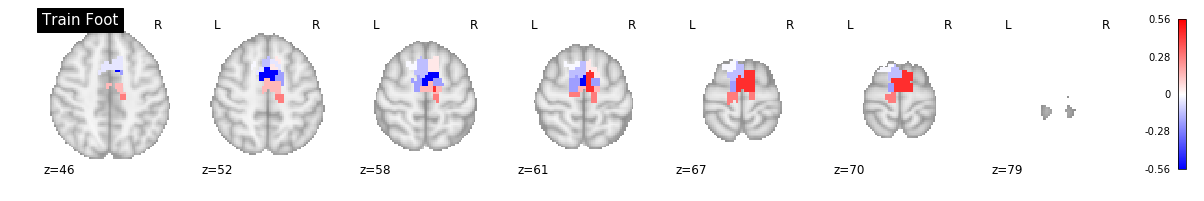

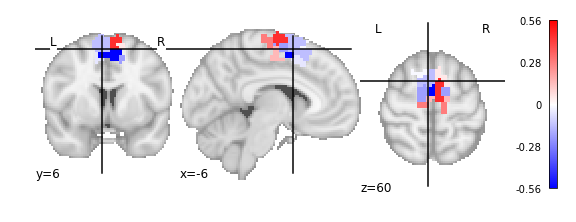

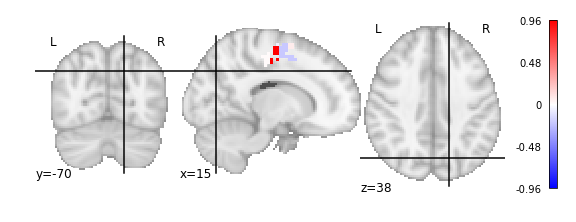

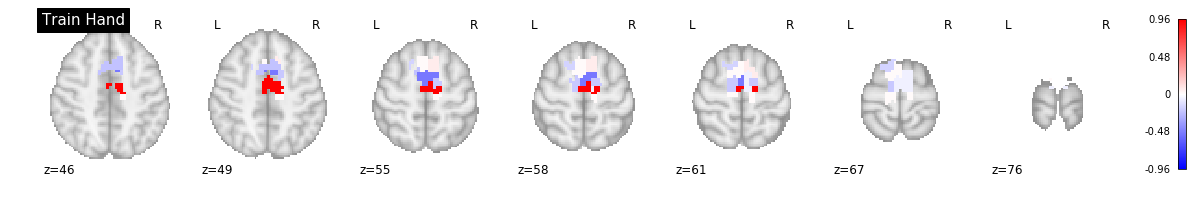

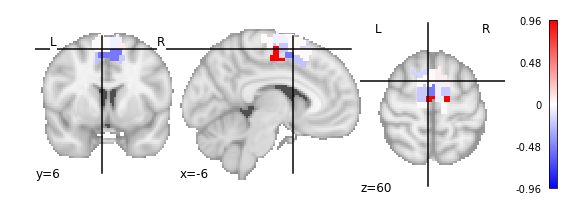

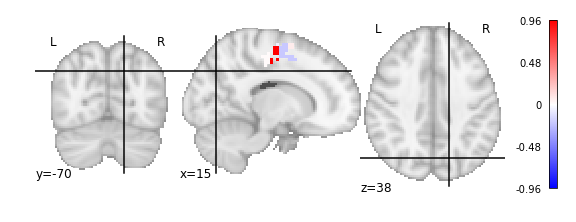

In [24]:
# Plot resulting weights of the SVM & selected regions

#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)
coef_tr_f=np.zeros([1,444])
coef_tr_h=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    coef_tr_f[0,n-1]=coef_f[0,i]
    coef_tr_h[0,n-1]=coef_h[0,i]
from nilearn.plotting import plot_stat_map
weight_img_trf = masker.inverse_transform(coef_tr_f)
weight_img_trh = masker.inverse_transform(coef_tr_h)
plot_stat_map(weight_img_trf, title='Train Foot',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trf,cmap='bwr', cut_coords=[-6, 6, 60])
plot_stat_map(weight_img_trh,cmap='bwr', cut_coords=[15, -70, 38])

plot_stat_map(weight_img_trh, title='Train Hand',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trh,cmap='bwr', cut_coords=[-6, 6, 60])
plot_stat_map(weight_img_trh,cmap='bwr', cut_coords=[15, -70, 38])

In [25]:
cv = LeaveOneLabelOut(block)
score_cv = cross_val_score(pipeline, roi_m_train, y_train,cv=cv)
print('FOOT only CV',score_cv.mean())
score_cv = cross_val_score(pipeline, roi_m_test, y_train,cv=cv)
print('HAND only CV',score_cv.mean())

FOOT only CV 0.566137566138
HAND only CV 0.605417529331


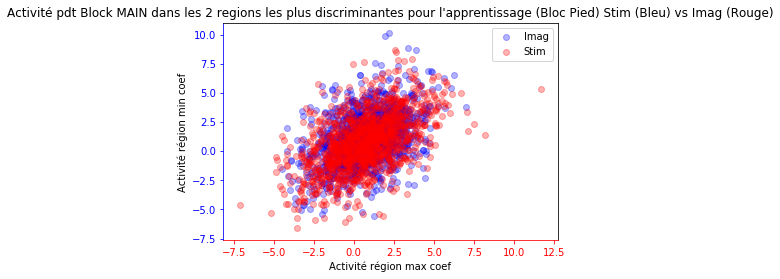

In [26]:
import matplotlib.pyplot as plt
amax_S=roi_m_test[y_train==b'stim',coef_f.argmax()]
amax_I=roi_m_test[y_train==b'imag',coef_f.argmax()]
amin_S=roi_m_test[y_train==b'stim',coef_f.argmin()]
amin_I=roi_m_test[y_train==b'imag',coef_f.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_I,amin_I,c='b',alpha=0.3,label='Imag')
ax.scatter(amax_S,amin_S,c='r',alpha=0.3,label='Stim')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
#plt.xlim(-10,10)
#plt.ylim(-15,15)
plt.title("Activité pdt Block MAIN dans les 2 regions les plus discriminantes pour l'apprentissage (Bloc Pied) Stim (Bleu) vs Imag (Rouge)")

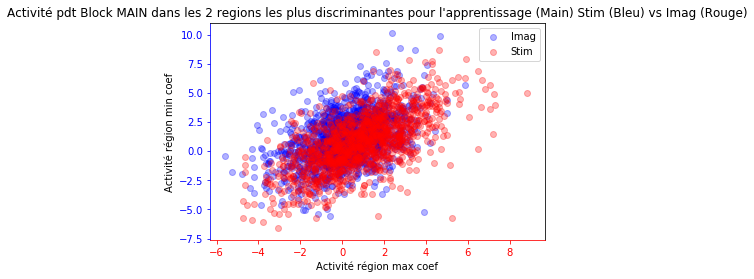

In [27]:
import matplotlib.pyplot as plt
amax_S=roi_m_test[y_train==b'stim',coef_h.argmax()]
amax_I=roi_m_test[y_train==b'imag',coef_h.argmax()]
amin_S=roi_m_test[y_train==b'stim',coef_h.argmin()]
amin_I=roi_m_test[y_train==b'imag',coef_h.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_I,amin_I,c='b',alpha=0.3,label='Imag')
ax.scatter(amax_S,amin_S,c='r',alpha=0.3,label='Stim')

plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
#plt.xlim(-10,10)
#plt.ylim(-15,15)
plt.title("Activité pdt Block MAIN dans les 2 regions les plus discriminantes pour l'apprentissage (Main) Stim (Bleu) vs Imag (Rouge)")

(array([   3.,   28.,   70.,  176.,  369.,  366.,  204.,   78.,   14.,    3.]),
 array([-5.57778837, -4.43272529, -3.28766221, -2.14259914, -0.99753606,
         0.14752702,  1.29259009,  2.43765317,  3.58271624,  4.72777932,
         5.8728424 ]),
 <a list of 10 Patch objects>)

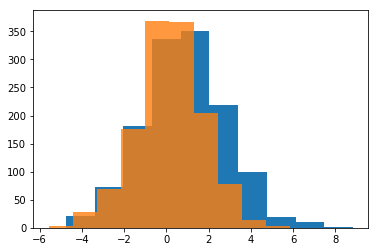

In [28]:
plt.hist(amax_S)
plt.hist(amax_I,alpha=0.8)

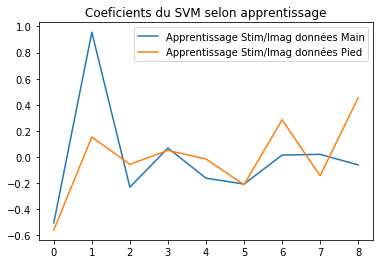

In [29]:
import matplotlib.pyplot as plt
plt.plot(coef_h.T,label='Apprentissage Stim/Imag données Main')
plt.plot(coef_f.T,label='Apprentissage Stim/Imag données Pied')
plt.title('Coeficients du SVM selon apprentissage')
plt.legend()

### Test du niveau de chance (en gardant la structure de bloc)

In [30]:
### Permutation block
pipeline.fit(roi_m_train, y_train)
prediction = pipeline.predict(roi_m_test)  
result_tr_stim=accuracy_score(prediction,y_test)

pipeline.fit(roi_m_test, y_test)
prediction = pipeline.predict(roi_m_train)  
result_tr_imag=accuracy_score(prediction,y_train)

nb_p=1000
null_result_tr_stim=np.zeros(nb_p)
null_result_tr_imag=np.zeros(nb_p)
nb_s=len(names)
ncond=['stim','imag']
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    # shuffle block number
    for suj in range(nb_s):
        xncond=np.random.permutation(ncond)
        suj_train_random=np.append(np.full(57,xncond[0],dtype='S12'),np.full(57,xncond[1],dtype='S12'))
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_m_train, y_train_random)
    prediction = pipeline.predict(roi_m_test) 
    null_result_tr_stim[i]=accuracy_score(prediction,y_test)
    
    pipeline.fit(roi_m_test, y_train_random)
    prediction = pipeline.predict(roi_m_train) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_train)

sign_tr_stim=(null_result_tr_stim>=result_tr_stim).sum()/nb_p
sign_tr_imag=(null_result_tr_imag>=result_tr_imag).sum()/nb_p
print('Train Foot',sign_tr_stim,'Train Hand',sign_tr_imag,)

KeyboardInterrupt: 

In [ ]:
val=0.1
above=np.logical_and(abs(coef_h)>val, np.abs(coef_f)>val)
print(above.sum())
diff=np.sign(coef_h)==np.sign(coef_f)
index=np.logical_and(above,diff)
print(index.sum())

roi_index=np.zeros(coef_h.shape)
for i in range(coef_h.shape[1]):
    if index.T[i]:
        if np.sign(coef_h.T[i])==1:
            roi_index.T[i]=1
        else:
            roi_index.T[i]=-1
              

roi=np.zeros([1,444])
for i,n in enumerate(motor_region_index):
    roi[0,n-1]=roi_index[0,i]
weight = masker.inverse_transform(roi)
plot_stat_map(weight, title='Regions',display_mode='z',cmap='bwr')